## kWh Analytics Data Science Challenge
Due: 8/22/2018

Background
There is a wide variety of solar panels on the market. Photovoltaic panel models vary in efficiency and durability based on the materials and manufacturing practices. Given field performance data, can we determine if a panel manufacturer's quality is changing with time?

In the attached file "datasci_takehome.csv.gz", we provide monthly performance data from systems that all use panels from manufacturer X. Each system also has a particular vintage (A, B, or C) corresponding to the year that the panel was manufactured.

The performance comes in the form of expectedkwh (the expected energy produced in kWh) and correctedkwh (the actual energy produced, weather corrected, in kWh). The metric that we use to benchmark performance is called the Performance Ratio (PR). In this case, the PR is computed as correctedkwh / expectedkwh. In any given month, a system that underperforms its expectation has a PR less than 1, and a system that overperforms its expectation has a PR greater than 1. 

Question
Is there reason to believe that panel manufacturer X's quality is changing year-to-year?

Guidelines
- Explain your answer. Show your thought process.
- Support your answer with valid Python code. Your approach should be repeatable given new data.
- Use the Python modules you are most comfortable with.
- Feel free to use tables or visualizations if they help support your answer.
- Submit your answer in a Jupyter notebook containing code and written conclusions.
- Please, take no longer than 4 hours. Tackle the problem at your convenience.


# Methodology:
 Feel free to look through this as you go down this file
#### Read File
1. Read CSV
2. There are two columns added. One is added to store performance ratio and one for sample counting purposes.

#### EDA-Exploratory Data Analysis
1. Look at high level basic stats of the dataset
2. Define visualization functions and one for splitting among vintage years
3. Visualize performance ratio, expectedkwh, and correctkwh by month. Unsurprisingly, there seems to seasonality variance for the latter two via visual observation, however not apparent for the performance ratio. 
4. Generate same visuals after splitting among vintage years. Here, its noted that there are hints of a data imbalance among months especially for vintage year A.
5. There is also a data imbalance among the vintage years.
6. Visualizing for effects between performance ratio and expectedkwh. It seems cluster but no obvious correlation.
7. Verify there is only very weak correlation with performance ratio for expectedkwh and correctedkwh. This is exected by first scaling the data and executing a correlation matrix. The limitation here is that we have only verified linear relationships. 
8. Conclusion of the data imbalance is presented. There is an imbalance by month and by vintage year. The reason for this remains unknown and presents limitations to the strategy that relies on balanced data sets. 
9. Performance ratio seems to indicate weak correlation with month/seasons.

#### Hypothesis Testing
1. Due to the data set imbalance, we do not want to use months with insignificant data samples. For example, month 1 has roughly 1 data point for vintage year A. Accordingly, months with sufficient data is preferred thus months 11 and 12 are used.

2. To use months 11 and 12, hypothesis testing via t-test is used to verify that the two samples (month 11 and 12) are statistically insignificant. The null hypothesis is not rejected; the samples are likely from the same population thus the analysis will go forward with datasets from months 11 and 12. Given more time, it is worth pursuing more months to create a larger sample set to work on, however the more months you introduce, the larger the data imbalance represented in the smaller months.

3. Using ANOVA, a three sample (Vintage years A, B, C) hypothesis test is conducted to determine their statistical significance. By the F-Test the null hypthesis is rejected; concluding that it is unlikely that the three samples shre the same population. There is strong evidence of vintage years having an effect on the panel manufacturer's quality.

4. Hypothesis testing was used for several reasons to reach such conclusion. First, because the independent variables (vintage years) were categorial, quantitative modeling such as regression would provide little value; regression would yield only three coefficients for each vintage year. In other words, such regression would aim to quantify a SINGLE performance ratio for each vintage year. This would not give much value because by the EDA we have discovered that there is variability in the performance ratio that is a cause of other factors besides vintage year. Second, categorical modeling was also not recommended for this because the data showed signs of imbalance. If categorical modeling was used for months 11 and 12 (similarly in this script), the model would already be introduced to data imbalance; the model may yield unwanted unbalanced results. 

In [ ]:
# Library Imports
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from statsmodels.stats import weightstats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

In [ ]:
# Read Given Data and Compute Performance Ratio as well as column for counting samples
df = pd.read_csv('datasci_takehome.csv')
df['performance ratio'] = df['correctedkwh']/df['expectedkwh']
df['count'] = 1
print df.head()
print df.info()

In [ ]:
# EDA: Exploratory Data Analysis
print df.describe()
print
print 'Vintage options are: ', df['vintage'].unique()
print 'There are ',df['system'].count(), ' systems'
print 'System-Vintage tags are unique combinations'

We find that system number is mere label and not an indicator of any quanititave value that assess the solar performance ratio. 

In [5]:
# Functions

# Split between different vintage years
def vintage_split(df):
    df_a = df[df['vintage']=='A']
    df_b = df[df['vintage']=='B']
    df_c = df[df['vintage']=='C']
    return df_a, df_b, df_c

# Visualization Functions
def vis_annual_system(system, df, tag):
    df_filtered = df[df['system'] == system]
    plt.figure(1)
    plt.scatter(df_filtered['month'],df_filtered[tag])
    plt.xlabel('month')
    plt.ylabel(tag)
    plt.title('system: '+ str(system) + ' vintage ' + str(df_filtered['vintage'].unique()[0]))
    plt.show()
    return

def vis_annual_systems(systems_list, df, tag):
    df_filtered = df[df['system'].isin(systems_list)]
    df_filtered_A, df_filtered_B, df_filtered_C = vintage_split(df_filtered)
    plt.figure(1)
    plt.scatter(df_filtered_A['month'],df_filtered_A[tag], color='r',label='A',s=5)
    plt.scatter(df_filtered_B['month'],df_filtered_B[tag], color='b',label='B',s=5)
    plt.scatter(df_filtered_C['month'],df_filtered_C[tag], color='g',label='C',s=5)
    plt.xlabel('month')
    plt.ylabel(tag)
    plt.show()
    return

def vis_month_systems(systems_list, df, month):
    df_filtered = df[df['system'].isin(systems_list)]
    df_filtered = df_filtered[df_filtered['month']==month]
    df_a, df_b, df_c = vintage_split(df_filtered)
    plt.figure(1)
    plt.scatter(df_a['correctedkwh'],df_a['performance ratio'], color='r',label='A',s=5)
    plt.scatter(df_b['correctedkwh'],df_b['performance ratio'], color='b',label='B',s=5)
    plt.scatter(df_c['correctedkwh'],df_c['performance ratio'], color='g',label='C',s=5)
    plt.xlabel('correctedkwh')
    plt.ylabel('performance ratio')
    plt.legend()
    plt.title('month: '+str(month))
    plt.show()

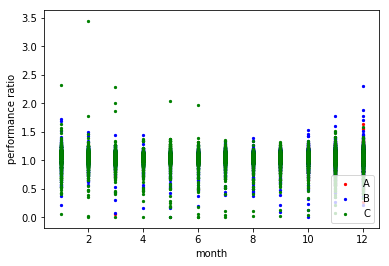

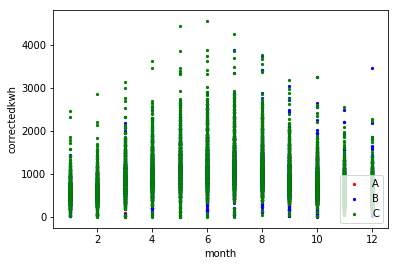

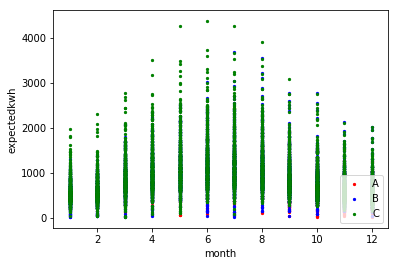

In [6]:
# Visual Exploration
# Performance Ratio by month
vis_annual_systems(df['system'].unique(), df, 'performance ratio')
vis_annual_systems(df['system'].unique(), df, 'correctedkwh')
vis_annual_systems(df['system'].unique(), df, 'expectedkwh')


Above, we see that a large proportion of the data is attributed to green, which is vintage year C and very little data is from year A. 

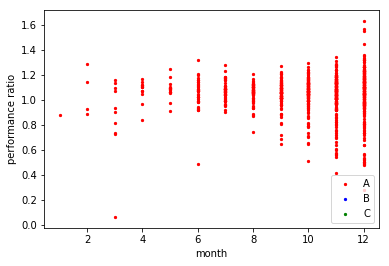

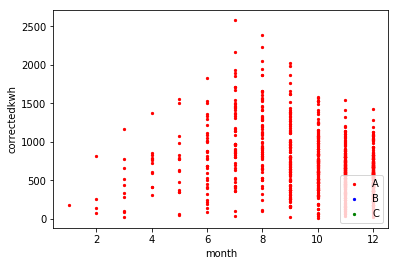

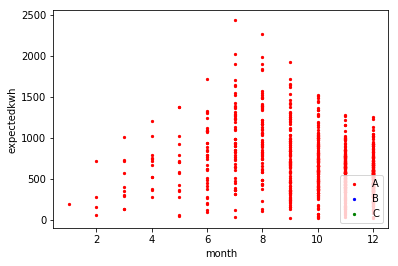

In [7]:
# Visualize Vintage A
vis_annual_systems(df['system'].unique(), df[df['vintage']=='A'], 'performance ratio')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='A'], 'correctedkwh')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='A'], 'expectedkwh')

We have filtered out and left with only vintage year A. It seems there are only a handful of data points from months 1 to 4. We have not necessarily confirmed that the months corresponding to a certain month; for example "1" does not necessarily correspond to January here. 

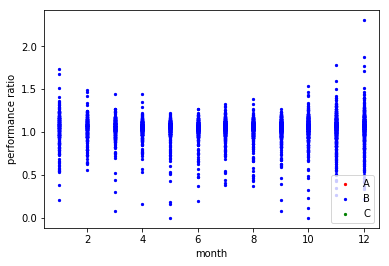

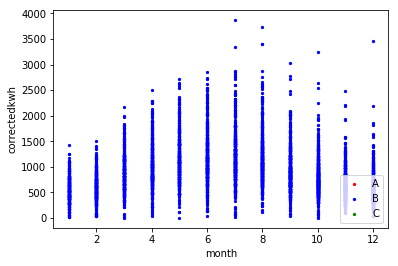

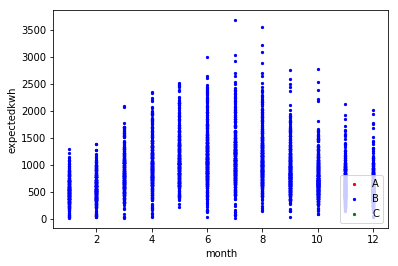

In [8]:
# Visualize vintage B
vis_annual_systems(df['system'].unique(), df[df['vintage']=='B'], 'performance ratio')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='B'], 'correctedkwh')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='B'], 'expectedkwh')

Similarly for vintage year B.

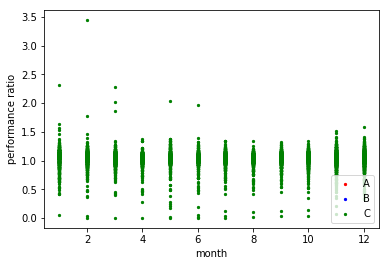

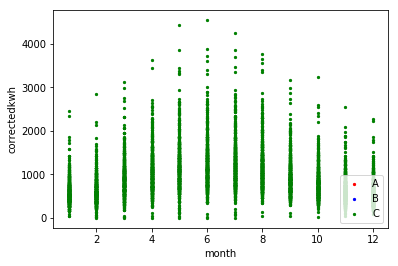

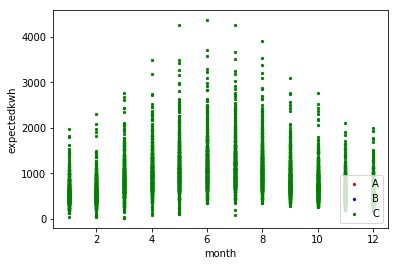

In [33]:
# Visualize vintage C
vis_annual_systems(df['system'].unique(), df[df['vintage']=='C'], 'performance ratio')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='C'], 'correctedkwh')
vis_annual_systems(df['system'].unique(), df[df['vintage']=='C'], 'expectedkwh')

and year C.

Currently, there are many unknowns. We do not know the vintage years' order, neither do we have any context on expectedkwh' computation nor the locational attributes of these systems. All in all, the data has no description to link to physical attributes of solar panels.  

In [34]:
# Is there a possible Data Imbalance?
df_A = df[df['vintage'] == 'A']
df_B = df[df['vintage'] == 'B']
df_C = df[df['vintage'] == 'C']
print df_A['performance ratio'].describe(), 'there are ',len(df_A['system'].unique()),' systems'
print df_B['performance ratio'].describe(), 'there are ',len(df_B['system'].unique()),' systems'
print df_C['performance ratio'].describe(), 'there are ',len(df_C['system'].unique()),' systems'

count    902.000000
mean       1.045362
std        0.150320
min        0.059249
25%        0.990888
50%        1.066049
75%        1.129677
max        1.630480
Name: performance ratio, dtype: float64 there are  249  systems
count    5372.000000
mean        1.040297
std         0.136079
min         0.000008
25%         1.000925
50%         1.059045
75%         1.105460
max         2.302019
Name: performance ratio, dtype: float64 there are  569  systems
count    7795.000000
mean        1.028475
std         0.139864
min         0.000019
25%         0.986396
50%         1.046112
75%         1.095802
max         3.443744
Name: performance ratio, dtype: float64 there are  673  systems


For modeling, our end goal is to understand how vintage year is correlated with performance ratio. 
We define "changing" referred in the main question.
"changing": as long as there exists a significant quantitative delta in the performance ratio that is beyond the margin of error, we can count that as change. 


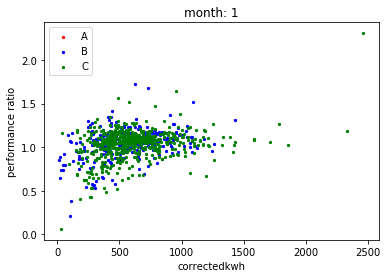

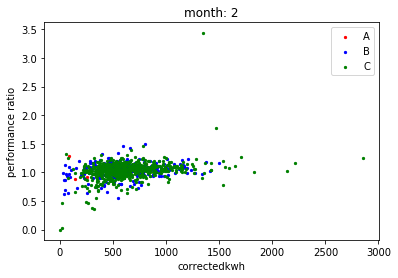

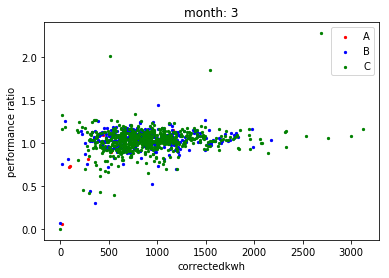

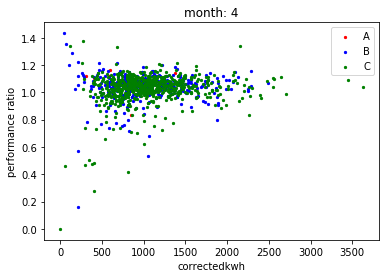

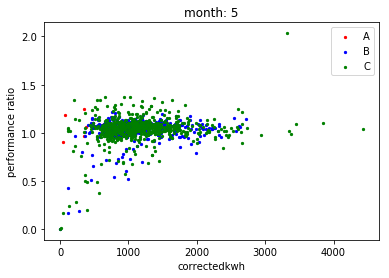

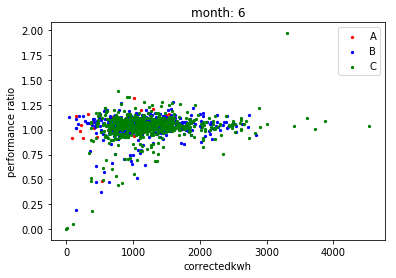

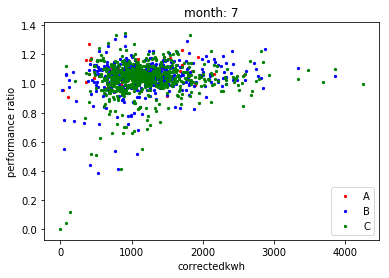

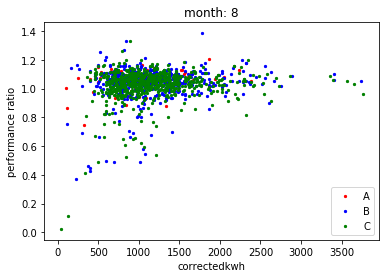

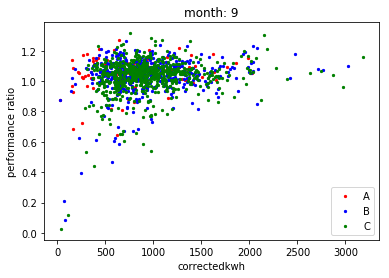

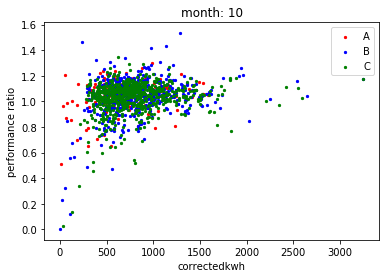

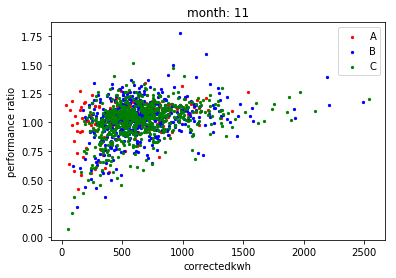

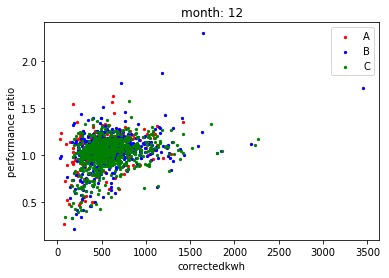

In [41]:
# Visualize Magnitude v Performance Ratio
for i in range(1,13):
    vis_month_systems(df['system'].unique(), df, i)

Above, we explore the effects of kwh production on the value of performance ratio. There is no clear indication of clustering that separates among the vintage years on this particular plot. 

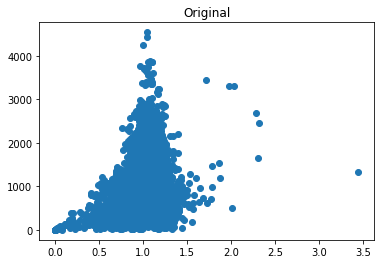

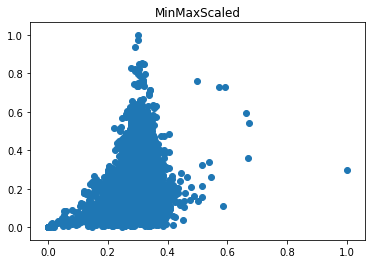

                   correctedkwh  performance ratio  expectedkwh
correctedkwh           1.000000           0.173811     0.961502
performance ratio      0.173811           1.000000    -0.066513
expectedkwh            0.961502          -0.066513     1.000000


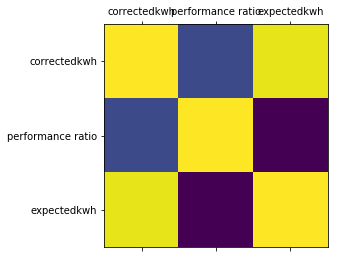

In [36]:
# Check for correlation between performance ratio, correctedkwh, and expectedkwh
# Scale data / Normalize

scaler = preprocessing.MinMaxScaler()
scaler.fit(df[['correctedkwh','performance ratio','expectedkwh']])
scaled_data = scaler.transform(df[['correctedkwh','performance ratio','expectedkwh']])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = [['correctedkwh','performance ratio','expectedkwh']]

# Check if scaled correctly
plt.figure(1)
plt.scatter(df['performance ratio'],df['correctedkwh'])
plt.title('Original')
plt.show()
plt.figure(2)
plt.scatter(scaled_data['performance ratio'],scaled_data['correctedkwh'])
plt.title('MinMaxScaled')
plt.show()
corr_mat = scaled_data[['correctedkwh','performance ratio','expectedkwh']].corr()

# Correlation Matrix
print corr_mat
plt.figure(3)
plt.matshow(corr_mat)
plt.xticks([0,1,2],['correctedkwh','performance ratio','expectedkwh'])
plt.yticks([0,1,2],['correctedkwh','performance ratio','expectedkwh'])
plt.show()




There is no significant correlation with performance ratio wither neither correctedkwh nor expected kwh. Given more time, it may be of worth checking to look for nonlinear correlation between correctkwh/expectedkwh with performance ratio.

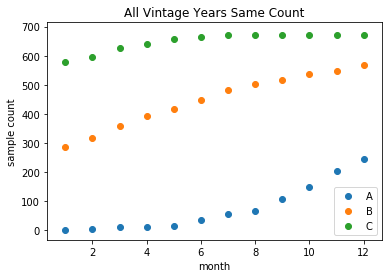

,system,correctedkwh,expectedkwh,performance ratio,count
month,,,,,
1,571268,5.112094e+05,4.942064e+05,897.838301,866
2,620877,5.762483e+05,5.554635e+05,953.083144,917
3,701777,8.896245e+05,8.644494e+05,1027.788330,994
4,756597,1.090189e+06,1.064148e+06,1076.439383,1044
5,810068,1.263994e+06,1.226542e+06,1130.710911,1091
6,856149,1.365392e+06,1.334067e+06,1183.198090,1148
7,907321,1.450420e+06,1.407799e+06,1250.503768,1207
8,934380,1.436194e+06,1.396664e+06,1279.960491,1239
9,966215,1.205368e+06,1.169497e+06,1340.729858,1296


In [42]:
# Visuals for Data Imbalance
df_a, df_b, df_c = vintage_split(df)
df_a_sum = df_a.groupby('month').sum()
plt.figure(1)
plt.scatter(df_a_sum.index,df_a_sum['count'], label='A')
df_b_sum = df_=df_b.groupby('month').sum()
plt.scatter(df_b_sum.index,df_b_sum['count'], label='B')
df_c_sum = df_=df_c.groupby('month').sum()
plt.scatter(df_c_sum.index,df_c_sum['count'], label='C')
plt.ylabel('sample count')
plt.title('All Vintage Years Same Count')
plt.xlabel('month')
plt.legend(loc=4)
plt.show()

df.groupby('month').sum()

# takeaway: Vintage A: exponential increase in data over months
# vintage b: linear
# vintage c: logarithmic
# all vintages: linear increase in data over months
# Why does the data count increase towards month 12?
# IMBALANCED DATA SET

Example from PV syst Report
<img src="Screen Shot 2018-08-18 at 12.32.08 PM.png">
Takeaway: Seasonality is verified with peak around June and minimum around December. 
This is a California site . 
Note that performance ratio is rather flat across the seasons.


Dec Normal Test
Given data is not normally distributed: p= 2.78718036139e-51
Nov Normal Test
Given data is not normally distributed: p= 7.93596501124e-72


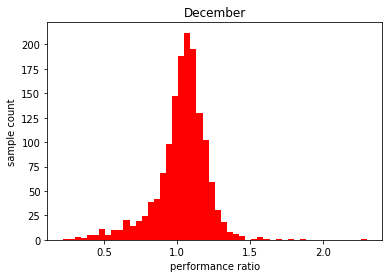

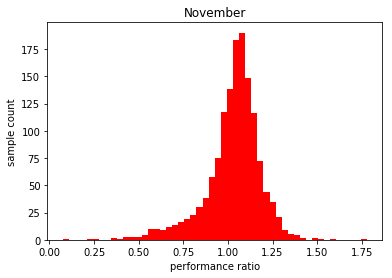

T Test, Stat NOT significant P-value:  0.391192917636
The p-value of  0.391192917636 is NOT statistically signiicant between months 11 and 12


In [38]:
# Let's verify that performance ratio is unaffected by seasons via hypothesis testing
# Why are we doing this: so we can answer the main question without having to worry about seasons
# Choose two extremes for seasons: June & December

def normal_test(data, sig_level):
    k2, p = scipy.stats.normaltest(data)
    if p > sig_level:
        print "Given data is normally distributed: p=", p
    else:
        print 'Given data is not normally distributed: p=',p
    return p
def z_test_two_sample(sample1, sample2):
    z_score, p_value = weightstats.ztest(sample1, sample2)
    return z_score, p_value
def t_test_two_sample(sample1, sample2, sig_level):
    t_score, p_value, sigma = weightstats.ttest_ind(sample1, sample2, alternative='two-sided')
    if p_value < sig_level:
        print "T Test, Stat significant P-value: ", p_value
    else: 
        print "T Test, Stat NOT significant P-value: ",p_value
    return t_score, p_value

sig = 0.05
sample1 = df[df['month'] ==12]['performance ratio']
sample2 = df[df['month'] ==11]['performance ratio']

# Normal Test
print "Dec Normal Test"
normal_test(sample1, sig)
print "Nov Normal Test"
normal_test(sample2, sig)

plt.figure(1)
plt.hist(sample1, bins=50, histtype='bar',color='r')
plt.title('December')
plt.ylabel('sample count')
plt.xlabel('performance ratio')
plt.show()

plt.figure(2)
plt.hist(sample2, bins=50, histtype='bar',color='r')
plt.title('November')
plt.ylabel('sample count')
plt.xlabel('performance ratio')
plt.show()

# Not normal, so we use the ttest
t_score, p_t = t_test_two_sample(sample1,sample2,sig)
# null: they are equal
# alternative: they are not equal
if p_t < sig:
    print "The p-value of ",p_t, 'is statistically significant, null hypothesis is rejected for the two sample t-test'
else:
    print "The p-value of ",p_t, 'is NOT statistically signiicant between months 11 and 12'
# We are interested in using data from November and December because they have the most data. 

Null Hypothesis: The two samples are from the same population
Alternative Hypothesis: The two samples are statistically significant, they are from separate populations. 
Null hypothesis was NOT rejected for samples between months 11 and 12. 

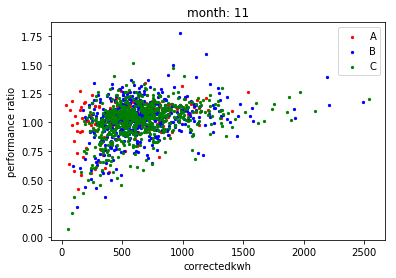

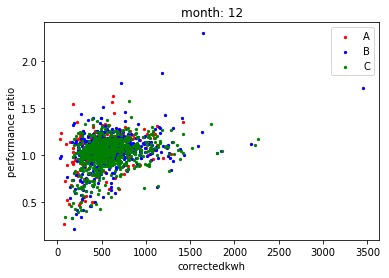

          system  month   correctedkwh    expectedkwh  performance ratio  \
vintage                                                                    
A         153165   5185  250909.261088  240585.803977         468.187511   
B         838224  12845  705047.621452  679717.981794        1163.556836   
C        1164900  15444  833282.185915  819881.889197        1367.768082   

         count  
vintage         
A          449  
B         1116  
C         1343  


In [39]:
# Filter for November and December
df_11_12 = df[df['month'].isin([11,12])]
vis_month_systems(df_11_12['system'].unique(), df_11_12,11)
vis_month_systems(df_11_12['system'].unique(), df_11_12,12)
print df_11_12.groupby('vintage').sum()


In [3]:
# ANOVA
# Hypothesis Test Between Three Samples: vintage A, B, C via F-Test
df_11_12['performanceratio'] = df_11_12['performance ratio']
sig = 0.05
lm = ols(formula = 'performanceratio ~ vintage', data=df_11_12).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 Anova DataFrame
print(table)
if table.iloc[0][3] < sig:
    print "Null Hypothesis rejected, p =",table.iloc[0][3]
else:
    print "Failed to reject null hypothesis, p =",table.iloc[0][3]
df_11_12_a, df_11_12_b, df_11_12_c = vintage_split(df)
print " The means per vintage year are:"
print df_11_12_a['performance ratio'].mean()
print df_11_12_b['performance ratio'].mean()
print df_11_12_c['performance ratio'].mean()
print " The medians per vintage year are:"
print df_11_12_a['performance ratio'].median()
print df_11_12_b['performance ratio'].median()
print df_11_12_c['performance ratio'].median()
data_box = [df_11_12_a['performance ratio'],df_11_12_b['performance ratio'],df_11_12_c['performance ratio']]
plt.figure(1)
plt.boxplot(data_box)
plt.ylabel('performance ratio')
plt.xlabel('vintage years A B C')
plt.ylim([1.01,1.12])
plt.title('Close up Box Plot of PR across vintage years')
plt.show()



NameError: name 'df_11_12' is not defined

## Anova F-Test
-Analysis for variance for 3 or more samples.

Null Hypothesis: the three samples are from the same population.

Alternative Hypothesis: the three samples are not from the same population. 

Interpret the ANOVA & F-Test:
In the different vintage groups, the total sum squared variance is 0.42 which is not insignificant, denoted by
F = 7.37, p=0.000639 which is smaller than our significance level of 0.05. The null hypothesis is rejected. To verify the claim, we examine that the means. Vintage year A and B are rather close but that is not the case for C. Because the mean is susceptible to outliers/extreme values we also examine the medians to further investigate the samples' centrality; accordingly the medians show significant difference among all vintage years. 